# Lab assignment: fraud detection through ensemble methods

<img src="img/fraud.jpg" style="width:600px;">

In this assignment we will use all the skills in ensemble learning we acquired from previous exercises to build a an automated fraud detection system.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">You will need to solve a question by writing your own code or answer in the cell immediately below, or in a different file as instructed. Both correctness of the solution and code quality will be taken into account for marking.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">This is a hint or useful observation that can help you solve this assignment. You are not expected to write any solution, but you should pay attention to them to understand the assignment.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">This is an advanced and voluntary excercise that can help you gain a deeper knowledge into the topic. This exercise won't be taken into account towards marking, but you are encouraged to undertake it. Good luck!</td></tr>
</table>

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Ensembles environment files](https://github.com/albarji/teaching-environments-ensembles).

The following code will embed any plots into the notebook instead of generating a new window:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Shift+Tab to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Data loading

The data for this problem is included in the *data* folder, with separate files for training and test data. Each file includes several unidentified explanatory features, together with an "Amount" feature and the target "Class". Fraudulent operations are marked as Class == 1.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Load the training and test data into Pandas DataFrames with names <b>train</b> and <b>test</b>, respectively.
 </td></tr>
</table>

In [2]:
import numpy as np
import pandas as pd

In [3]:
train = pd.read_csv("data/fraud_train.csv")
test = pd.read_csv("data/fraud_test.csv")

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Perform a brief analysis of the training data to answer the following questions: how many explanatory variables do you have? What is the distribution of classes?
 </td></tr>
</table>

In [4]:
print('Number of explanatory columns: ', len(train.columns) - 1)
print('Total training class "0": ', sum(train["Class"] == 0))
print('Total training class "1": ', sum(train["Class"] == 1))
print("1's ratio in training: ", sum(train["Class"] == 1)/(sum(train["Class"] == 1) + sum(train["Class"] == 0)))
print('Total test class "0": ', sum(test["Class"] == 0))
print('Total test class "1": ', sum(test["Class"] == 1))
print("1's ratio in test: ", sum(test["Class"] == 1)/(sum(test["Class"] == 1) + sum(test["Class"] == 0)))

Number of explanatory columns:  29
Total training class "0":  5000
Total training class "1":  246
1's ratio in training:  0.04689287075867327
Total test class "0":  5000
Total test class "1":  246
1's ratio in test:  0.04689287075867327


## Measuring the performance of a fraud detector

Fraudulent activities are usually prosecuted, therefore fraudsters need to be creative and come up constantly with new ways of performing fraud. Furthermore, frauds are scarce (fortunately), and so we have few positive class patterns available for training. This means the problem is highly unbalanced, which is a problem for training good models, but is also a problem for the model evaluation. 

Consider a dumb model that classifies all data as negative (non-fraud). We can simulate the predictions of this model by creating a predictions vector of all zeros:

In [5]:
dumbpreds = [0] * len(test)

Let's measure the accuracy of this model

In [6]:
from sklearn.metrics import accuracy_score

accuracy_score(test["Class"], dumbpreds)

0.9531071292413267

Yo should have obtained a 95% of accuracy, because most of the patterns are indeed negative. But this would be totally useless as a fraud detector! Therefore, we need a better metric.

One that works well for heavily unbalanced problems is the [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), or AUC in short. In scikit-learn this metric is readily available, and we can test how this reveals the poor performance of this dumb model

In [7]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test["Class"], dumbpreds)

0.5

An AUC of 50% means the model is no better than a random guess. We should aim to maximize this metric and attain a 100%, meaning all fraudulent patterns obtain higher scores than non-fraud patterns.

## Unsupervised fraud detector

Since we now we have scarce positive data, it might make sense to start building an unsupervised fraud detector.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Using <b>only the training data</b>, create an Isolation Forest model for anomaly detection. You can use the number of positive patterns in the data to adjust the contamination ratio. Then measure the performance of the model on the test set, in terms of AUC score.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Note the roc_auc_score metric must receive <b>positive class probabilities</b>. It is not possible to obtain these probabilities from an IsolationForest model, but you can make use of its decision_function method to obtain normality scores (average tree depth), which can be negated to obtain positive class scores.
 </td></tr>
</table>

In [8]:
X_train = train.loc[:, train.columns != "Class"]
y_train = train.loc[:, train.columns == "Class"]

X_test = test.loc[:, test.columns != "Class"]
y_test = test.loc[:, test.columns == "Class"]

data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test
}

In [9]:
from sklearn.ensemble import IsolationForest

In [10]:
isoforest = IsolationForest(contamination = 0.04689287075867327, random_state = 0)
isoforest.fit(X_train)

IsolationForest(contamination=0.04689287075867327, random_state=0)

In [11]:
y_pred_score = isoforest.decision_function(X_test)*(-1)
roc_auc_score(y_test,y_pred_score)

0.933129268292683

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Create a visualization showing the performance of this model over the test data. Suggestion: make use of the <a href=https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html>ROC plot portrayed in the scikit-learn docs</a>
 </td></tr>
</table>

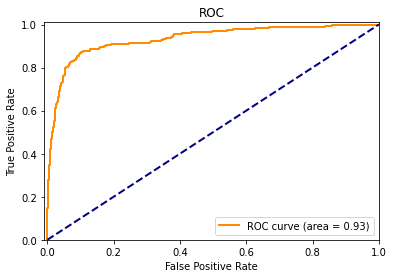

In [12]:
from sklearn.metrics import roc_curve, auc
fpr = []
tpr = []
roc_auc = []

fpr, tpr, _ = roc_curve(y_test, y_pred_score, pos_label=1)
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Supervised models

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Let's check now whether we can improve the results using supervised models, that is, models that exploit the Class information available in the training data. Try <b>at least five</b> ensemble-based classification models, <b>using only the data in the training set</b>.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
Some suggestions on the scikit-learn models you can use are: Random Forest, Extra Trees, AdaBoost, Gradient Boosting,  Bagging, Voting and Stacking. You can also use an XGBClassifier, also included in this environment.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Bonus points will we awarded for:
     <ul>
         <li>Trying more ensemble strategies beyond the minimum requirement of five.</li>
         <li>Improving the AUC score of your best model as much as possible.</li>
         <li>Trying <a href=https://catboost.ai/>CatBoost</a> and/or <a href=https://lightgbm.readthedocs.io/en/latest/>LightGBM</a>, other two popular ensemble methods. Note you will need to install these in your environment.</li>
     </ul>
 </td></tr>
</table>

In [13]:
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier,
                              BaggingClassifier,
                              VotingClassifier,
                              StackingClassifier)
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Model Trainer

In [14]:
class ModelTrainer:

    def __init__(self, model, data, params_dist):

        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_test = data['X_test']
        self.y_test = data['y_test']
        
        self.model = model
        self.params_dist = params_dist
    
    
    def autofit(self, n_iter=1):


        trained_model = RandomizedSearchCV(
                                               self.model,
                                               self.params_dist,
                                               n_iter = n_iter,
                                               n_jobs = 3,
                                               random_state = 0,
                                               )
            
            
        trained_model.fit(self.X_train, self.y_train)

        self.trained_model = trained_model
        self.best_score = trained_model.score(self.X_test, self.y_test)

        print('Training ended with a training score of ', trained_model.best_score_)
        print('Best params:')
        print(trained_model.best_params_)

        return trained_model

    
    def test(self):
        
        if self.trained_model:
            preds = self.trained_model.predict_proba(self.X_test)
            preds_1 = [row[1] for row in preds]
            
            auc = roc_auc_score(self.y_test, preds_1)
            self.auc = auc
            
            fpr, tpr, _ = roc_curve(self.y_test, preds_1, pos_label=1)
            self.fpr = fpr
            self.tpr = tpr
            
            return auc
        
        else:
            raise Exception('Model not fitted. Try the .autofit method.')
        
        
    def plot_roc(self):
        if self.fpr.any():
            lw = 2
            plt.plot(self.fpr, self.tpr, color='darkorange',
                     lw=lw, label='ROC curve (area = %0.2f)' % self.auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([-0.01, 1.0])
            plt.ylim([0.0, 1.01])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC')
            plt.legend(loc="lower right")
            plt.show()
        else:
            raise Exception('Model not tested. Try the .test method.')


### Random Forest Classifier

In [15]:
param_dist = {
    "n_estimators" : [50],
    "max_depth": [3, 5, 10, 15, 20, 25, 30, None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_split": [2, 4, 8, 16, 32, 64],
    "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "random_state": [0]
}

RandomForestTrainer = ModelTrainer(RandomForestClassifier(),
                                   data,
                                   param_dist)
RandomForestTrainer.autofit(1)
RandomForestTrainer.test()

Training ended with a training score of  0.9881812156702529
Best params:
{'random_state': 0, 'n_estimators': 50, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 25, 'criterion': 'gini', 'bootstrap': False}


0.9397719512195123

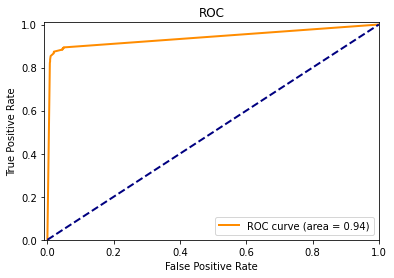

In [27]:
RandomForestTrainer.plot_roc()

### Extra trees

In [16]:
param_dist = {
    "n_estimators" : [50],
    "max_depth": [3, 5, 10, 15, 20, 25, 30, None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_split": [2, 4, 8, 16, 32, 64],
    "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "random_state": [0]
}

ExtraTreesTrainer = ModelTrainer(ExtraTreesClassifier(),
                                   data,
                                   param_dist)
ExtraTreesTrainer.autofit()
ExtraTreesTrainer.test()

Training ended with a training score of  0.9931370466203642
Best params:
{'random_state': 0, 'n_estimators': 50, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 25, 'criterion': 'gini', 'bootstrap': False}


0.9815036585365853

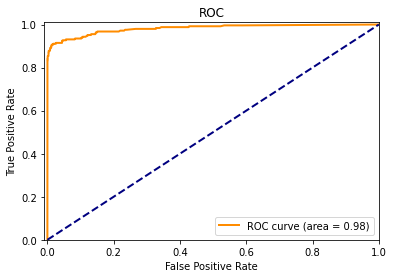

In [28]:
ExtraTreesTrainer.plot_roc()

### AdaBoost

In [17]:
param_dist = {
    "n_estimators" : [50],
    "learning_rate": np.logspace(-5,0,12),
    "random_state": [0]
}

AdaBoostTrainer = ModelTrainer(AdaBoostClassifier(),
                               data,
                               param_dist)
AdaBoostTrainer.autofit()
AdaBoostTrainer.test()

Training ended with a training score of  0.9872282899813882
Best params:
{'random_state': 0, 'n_estimators': 50, 'learning_rate': 0.005336699231206307}


0.9185256097560976

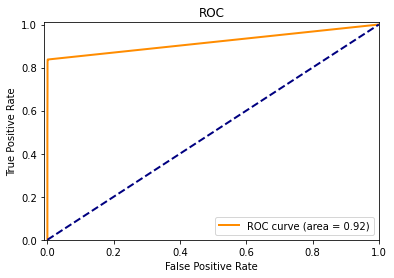

In [29]:
AdaBoostTrainer.plot_roc()

### Gradient Boosting

In [18]:
param_dist = {
    "n_estimators" : [50],
    "loss": ["deviance", "exponential"],
    "learning_rate": np.logspace(-5,0,12),
    "max_depth": [3, 5, 10, 15, 20, 25, 30, None],
    "min_samples_split": [2, 4, 8, 16, 32, 64],
    "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],
    "subsample" : [0.1, 0.2, 0.5, 0.9, 1],
    "max_features": ["sqrt", "log2", None],
    "random_state": [0]
}

GradientBoostingTrainer = ModelTrainer(GradientBoostingClassifier(),
                               data,
                               param_dist)
GradientBoostingTrainer.autofit()
GradientBoostingTrainer.test()

Training ended with a training score of  0.953107267692587
Best params:
{'subsample': 0.9, 'random_state': 0, 'n_estimators': 50, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'loss': 'exponential', 'learning_rate': 0.005336699231206307}


0.9786617886178861

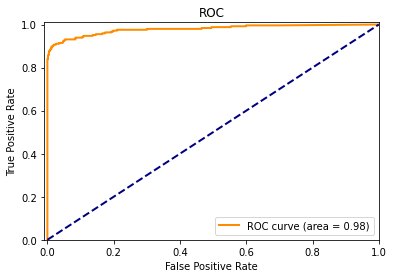

In [30]:
GradientBoostingTrainer.plot_roc()

### Bagging

In [19]:
param_dist = {
    "n_estimators" : [50],
    "max_features": [5,10,15,20,25,28],
    "bootstrap": [True, False],
    "random_state": [0]
}

BaggingTrainer = ModelTrainer(BaggingClassifier(),
                               data,
                               param_dist)
BaggingTrainer.autofit()
BaggingTrainer.test()

Training ended with a training score of  0.9919932815833674
Best params:
{'random_state': 0, 'n_estimators': 50, 'max_features': 5, 'bootstrap': False}


0.9707280487804878

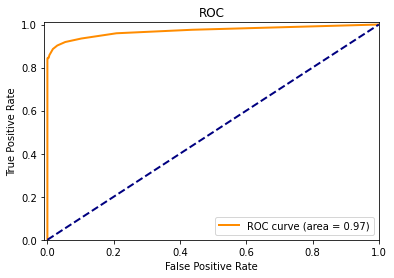

In [32]:
BaggingTrainer.plot_roc()

### XGBClassifier

In [20]:
param_dist = {
    'n_estimators': [50],
    'gamma' : [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'max_depth': [6, 9, 12],
    'subsample': [0.5, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.9, 1.0],
    'reg_lambda' : [0, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    "random_state": [0]
}

XGBTrainer = ModelTrainer(XGBClassifier(),
                               data,
                               param_dist)
XGBTrainer.autofit()
XGBTrainer.test()

[00:20:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ended with a training score of  0.9937090199282764
Best params:
{'subsample': 0.5, 'reg_lambda': 1, 'random_state': 0, 'n_estimators': 50, 'max_depth': 12, 'gamma': 1e-05, 'colsample_bytree': 0.9}


0.9765951219512194

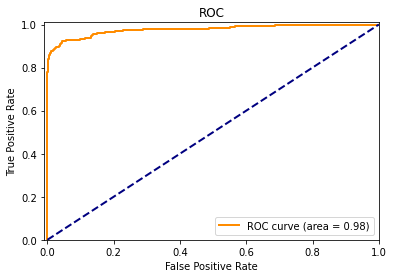

In [33]:
XGBTrainer.plot_roc()

### CatBoost

In [21]:
param_dist = {
    'iterations': [200],
    'loss_function' : ['Logloss', 'CrossEntropy', 'Tweedie'],
    'depth': [3, 6, 9, 12,],
    "random_seed": [42]
}

CatBoostTrainer = ModelTrainer(CatBoostClassifier(),
                               data,
                               param_dist)
CatBoostTrainer.autofit()
CatBoostTrainer.test()

Learning rate set to 0.091465
0:	learn: 0.5074295	total: 222ms	remaining: 44.2s
1:	learn: 0.3630069	total: 312ms	remaining: 30.9s
2:	learn: 0.2687289	total: 410ms	remaining: 26.9s
3:	learn: 0.2086471	total: 534ms	remaining: 26.2s
4:	learn: 0.1641536	total: 634ms	remaining: 24.7s
5:	learn: 0.1319646	total: 720ms	remaining: 23.3s
6:	learn: 0.1075806	total: 808ms	remaining: 22.3s
7:	learn: 0.0915508	total: 868ms	remaining: 20.8s
8:	learn: 0.0783301	total: 934ms	remaining: 19.8s
9:	learn: 0.0673570	total: 999ms	remaining: 19s
10:	learn: 0.0593309	total: 1.06s	remaining: 18.3s
11:	learn: 0.0520908	total: 1.12s	remaining: 17.6s
12:	learn: 0.0475838	total: 1.18s	remaining: 16.9s
13:	learn: 0.0431341	total: 1.23s	remaining: 16.3s
14:	learn: 0.0394892	total: 1.29s	remaining: 15.9s
15:	learn: 0.0366928	total: 1.35s	remaining: 15.5s
16:	learn: 0.0345257	total: 1.41s	remaining: 15.1s
17:	learn: 0.0325865	total: 1.47s	remaining: 14.9s
18:	learn: 0.0307819	total: 1.55s	remaining: 14.8s
19:	learn: 0.

162:	learn: 0.0027569	total: 9.97s	remaining: 2.26s
163:	learn: 0.0027535	total: 10s	remaining: 2.2s
164:	learn: 0.0027509	total: 10.1s	remaining: 2.14s
165:	learn: 0.0027292	total: 10.1s	remaining: 2.07s
166:	learn: 0.0026999	total: 10.2s	remaining: 2.01s
167:	learn: 0.0026974	total: 10.2s	remaining: 1.95s
168:	learn: 0.0026704	total: 10.3s	remaining: 1.89s
169:	learn: 0.0026349	total: 10.3s	remaining: 1.82s
170:	learn: 0.0025941	total: 10.4s	remaining: 1.76s
171:	learn: 0.0025563	total: 10.4s	remaining: 1.7s
172:	learn: 0.0025064	total: 10.5s	remaining: 1.64s
173:	learn: 0.0024748	total: 10.6s	remaining: 1.58s
174:	learn: 0.0024579	total: 10.6s	remaining: 1.52s
175:	learn: 0.0024351	total: 10.7s	remaining: 1.46s
176:	learn: 0.0024170	total: 10.8s	remaining: 1.4s
177:	learn: 0.0024155	total: 10.8s	remaining: 1.34s
178:	learn: 0.0023876	total: 10.9s	remaining: 1.28s
179:	learn: 0.0023862	total: 10.9s	remaining: 1.21s
180:	learn: 0.0023630	total: 11s	remaining: 1.15s
181:	learn: 0.00233

0.984928455284553

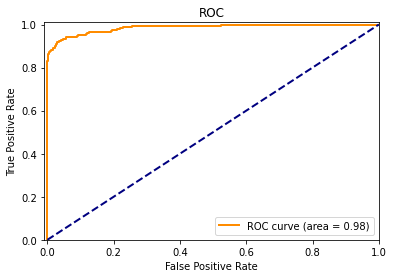

In [34]:
CatBoostTrainer.plot_roc()

### LightGBM

In [22]:
param_dist = {
    'boosting_type' : ['gbdt'],
    'num_leaves': [31, 21, 26, 16],
    'learning_rate': [0.1, 0.05, 0.03],
    'max_depth': [8, 16, 32],
    'n_estimators': [50, 100, 200],
    'min_child_samples': [3, 10, 20],
    "objective": ['binary'],
    "random_state": [0]
}

LGBMTrainer = ModelTrainer(LGBMClassifier(),
                               data,
                               param_dist)
LGBMTrainer.autofit()
LGBMTrainer.test()

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training ended with a training score of  0.9931372281991921
Best params:
{'random_state': 0, 'objective': 'binary', 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 16, 'learning_rate': 0.05, 'boosting_type': 'gbdt'}


0.9767268292682927

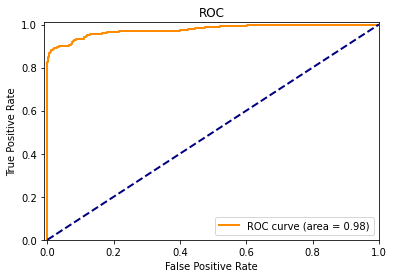

In [35]:
LGBMTrainer.plot_roc()

### Voting classifier

In [23]:
estimators = [
    ('RandomForest', RandomForestTrainer.trained_model),
    ('ExtraTrees', ExtraTreesTrainer.trained_model),
    ('GradientBoosting', GradientBoostingTrainer.trained_model),
    ('XGB', XGBTrainer.trained_model),
    ('CatBoosting', CatBoostTrainer.trained_model),
]

In [24]:
param_dist = {
    "voting" : ['soft']
}
VotingTrainer = ModelTrainer(VotingClassifier(estimators),
                               data,
                               param_dist)
VotingTrainer.autofit()
VotingTrainer.test()

[00:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.091465
0:	learn: 0.5074295	total: 62.2ms	remaining: 12.4s
1:	learn: 0.3630069	total: 115ms	remaining: 11.4s
2:	learn: 0.2687289	total: 167ms	remaining: 11s
3:	learn: 0.2086471	total: 224ms	remaining: 11s
4:	learn: 0.1641536	total: 283ms	remaining: 11.1s
5:	learn: 0.1319646	total: 336ms	remaining: 10.9s
6:	learn: 0.1075806	total: 387ms	remaining: 10.7s
7:	learn: 0.0915508	total: 441ms	remaining: 10.6s
8:	learn: 0.0783301	total: 497ms	remaining: 10.5s
9:	learn: 0.0673570	total: 549ms	remaining: 10.4s
10:	learn: 0.0593309	total: 601ms	remaining: 10.3s
11:	learn: 0.0520908	total: 654ms	remaining: 10.2s
12:	learn: 0.0475838	total: 708ms	remaining: 10.2s
13:	learn:

155:	learn: 0.0029763	total: 9.45s	remaining: 2.67s
156:	learn: 0.0029438	total: 9.5s	remaining: 2.6s
157:	learn: 0.0029366	total: 9.56s	remaining: 2.54s
158:	learn: 0.0029008	total: 9.62s	remaining: 2.48s
159:	learn: 0.0028635	total: 9.68s	remaining: 2.42s
160:	learn: 0.0028377	total: 9.74s	remaining: 2.36s
161:	learn: 0.0027779	total: 9.8s	remaining: 2.3s
162:	learn: 0.0027569	total: 9.87s	remaining: 2.24s
163:	learn: 0.0027535	total: 9.93s	remaining: 2.18s
164:	learn: 0.0027509	total: 9.99s	remaining: 2.12s
165:	learn: 0.0027292	total: 10.1s	remaining: 2.06s
166:	learn: 0.0026999	total: 10.1s	remaining: 2s
167:	learn: 0.0026974	total: 10.2s	remaining: 1.94s
168:	learn: 0.0026704	total: 10.2s	remaining: 1.88s
169:	learn: 0.0026349	total: 10.3s	remaining: 1.81s
170:	learn: 0.0025941	total: 10.3s	remaining: 1.75s
171:	learn: 0.0025563	total: 10.4s	remaining: 1.69s
172:	learn: 0.0025064	total: 10.5s	remaining: 1.63s
173:	learn: 0.0024748	total: 10.5s	remaining: 1.57s
174:	learn: 0.00245

0.9817105691056911

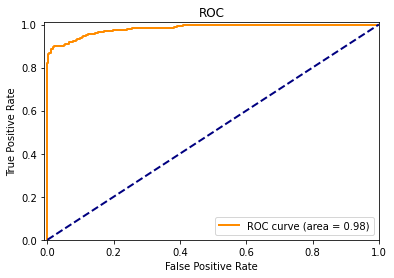

In [36]:
VotingTrainer.plot_roc()

### Stacking Classifier

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

estimators = [
    ('GradientBoosting', GradientBoostingTrainer.trained_model),
    ('ExtraTrees', make_pipeline(StandardScaler(),
                                 ExtraTreesTrainer.trained_model)),
    ('XGB', make_pipeline(StandardScaler(),
                                 XGBTrainer.trained_model)),
     ]

In [26]:
param_dist = {
    "final_estimator" : [LogisticRegression()],
}
StackingTrainer = ModelTrainer(StackingClassifier(estimators),
                               data,
                               param_dist)
StackingTrainer.autofit()
StackingTrainer.test()

[00:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:33:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:33:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:33:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.9834422764227642

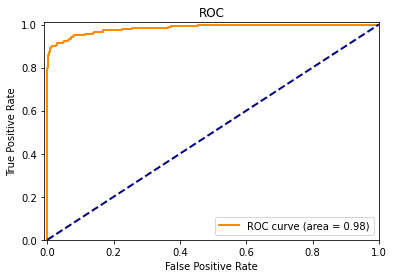

In [37]:
StackingTrainer.plot_roc()

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Now create a visualization showing the performance of your supervised models on the test set, together with the unsupervised model. Has the performance improved after making use of the Class data? Which model obtains the best AUC?
 </td></tr>
</table>